In [1]:
from tqdm import tqdm, trange
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import scipy as sp
import time
import sys
import importlib
import os
import hashlib
import subprocess
import gc

from IPython import display
from IPython.display import clear_output
import copy
from copy import deepcopy
# from sklearn.metrics import roc_auc_score, roc_curve

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset

# from captum.attr import IntegratedGradients
# from captum.attr import LayerConductance
# from captum.attr import NeuronConductance

try:
    import cPickle as pickle
except:
    import pickle
    
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

code_folder1="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/"
code_folder2=f"{code_folder1}/prediction_step_0/"

import sys
sys.path.append(code_folder1)
sys.path.append(code_folder2)


energy_folder="/home/energy/ykhalak/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF/"
energy_folder_workstation="/netmount/energy/ykhalak/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF/"
all_ligs_db_file_energy=f"{energy_folder_workstation}/full_ligs.pickle"


all_ligs_db_file_old="/home/ykhalak/Projects/ML_dG/pde2_dG/how_do_ligs_fit_in_pocket/adaptive_learning_test_from_morphed_structs/../processed_ligs_w_morphing_sim_annealing_only_sucessfull.pickle"
experiment_folder="/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF/"
all_ligs_db_file=f"{experiment_folder}/full_ligs.pickle"

datafolder=f"{experiment_folder}/cached_reprs"

# settings_folder=f"{experiment_folder}/combined_repr_search_with_repeats_and_mparam_scan/settings/"
# os.makedirs(settings_folder, exist_ok=True)


Bohr2Ang=0.529177249
RT=0.001985875*300 #kcal/mol


# Import training code

In [2]:
if 'custom_dataset_modular_with_binning_6EZF' in sys.modules:
    importlib.reload(sys.modules['custom_dataset_modular_with_binning_6EZF'])
else:
    import custom_dataset_modular_with_binning_6EZF
from custom_dataset_modular_with_binning_6EZF import dataBlocks, CustomMolModularDataset

if 'owl_trainer_w_params_general_with_ensemble_summary_model_6EZF' in sys.modules:
    importlib.reload(sys.modules['owl_trainer_w_params_general_with_ensemble_summary_model_6EZF'])
else:
    import owl_trainer_w_params_general_with_ensemble_summary_model_6EZF
from owl_trainer_w_params_general_with_ensemble_summary_model_6EZF import *

# Define representation blocks

In [3]:
flags_2D=[dataBlocks.MACCS, dataBlocks.Descriptors, dataBlocks.Graph_desc, dataBlocks.BCUT2D]
flags_3D=[dataBlocks.EState_FP, dataBlocks.Pharmacophore_feature_map,
          dataBlocks.MOE, dataBlocks.MQN, dataBlocks.GETAWAY, dataBlocks.AUTOCORR2D,
          dataBlocks.AUTOCORR3D, dataBlocks.WHIM, dataBlocks.RDF,
          dataBlocks.USR, dataBlocks.USRCUT, dataBlocks.PEOE_VSA, dataBlocks.SMR_VSA,
          dataBlocks.SlogP_VSA, dataBlocks.MORSE]

flags_2D_3D=flags_2D+flags_3D

# load active learner code

In [13]:
#! ln -s /home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0/utils.py $experiment_folder/utils.py

if 'active_learner_6EZF' in sys.modules:
    importlib.reload(sys.modules['active_learner_6EZF'])
else:
    import active_learner_6EZF
from active_learner_6EZF import *

# for running all at once:

In [18]:
normalize_x=True
shuffle_seed=12345678

#n_Epochs=2000
#hl_w=300
#hl_depth=2

n_Epochs=200
hl_w=20
hl_depth=1

init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

weighted=True
use_dropout=True
shiftY=True

redo=False

sele_rule=SelectionRule.narrowing

init_rules=[
    StartingSelectionMethod.random,
    #StartingSelectionMethod.weighted_by_2D_repr,
    #StartingSelectionMethod.weighted_by_RDKFP_Tanimoto,
    StartingSelectionMethod.from_two_Tanimoto_clusters,
    StartingSelectionMethod.from_Tanimoto_clusters2,
    StartingSelectionMethod.from_Tanimoto_clusters3,
    StartingSelectionMethod.from_Tanimoto_clusters4
]

n_picks_per_step=100

run_name_prefixes=[
    f"init_rule_random",
    #f"init_rule_weighted_2D",
    #f"init_rule_weighted_Tanimoto",
    f"init_rule_random_from_clusters",
    f"init_rule_random_from_clusters2",
    f"init_rule_random_from_clusters3",
    f"init_rule_random_from_clusters4"
]

init_method_sfiles=[]

# starting_method=StartingSelectionMethod.weighted_by_2D_repr

learner_settings_folder=f"{experiment_folder}/AL_settings"
os.makedirs(learner_settings_folder, exist_ok=True)

hl_w='auto'
hl_depth='auto'
n_Epochs='auto'



counter=0
unfinished=[]

repeats_fnames=[]
repeats_logfns=[]
for rule_id in range(len(init_rules)):
    this_init_method_sfiles=[]
    for r in range(5):
        run_name=f"{run_name_prefixes[rule_id]}_repeat_{r}"
#         sele_rule=sele_rules[rule_id]
        starting_method=init_rules[rule_id]
        starting_ligs_seed=123456+r
        learner_settings=[
            normalize_x, shuffle_seed, n_Epochs, init_learning_rate, learning_rate_decay, weight_decay,
            impfilt, X_filter, weighted, shiftY, use_dropout, sele_rule, starting_method, hl_w, hl_depth,
            starting_ligs_seed,n_picks_per_step,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,run_name
        ]

        sha = hashlib.sha256()
        sha.update(pickle.dumps(learner_settings))
        #settings_hash=dr_name+"_"+sha.hexdigest()[:10]
        #settings_fname=f"{learner_settings_folder}/learner_settings_repr_{settings_hash}.pickle"
        settings_hash=sha.hexdigest()[:6]

        settings_fname=f"{learner_settings_folder}/learner_settings_{run_name}_{settings_hash}.pickle"
        if(os.path.exists(settings_fname)):
            with open(settings_fname, 'rb') as f:
                settings_loaded, learner_metrics = pickle.load(f)
                if(learner_metrics is not None and not redo):
                    if(len(learner_metrics.top10_found)<7):
                        print(f"{settings_fname} has started but is not finished.")
                        unfinished.append(counter)
                    else:
#                         print(f"{settings_fname} has finished.")
                        pass
                else:
                    print(f"{settings_fname} exists but is not trained yet.")
                    unfinished.append(counter)
        else:
            pickle.dump( (learner_settings, None), open( settings_fname, "wb" ) )
            print(f"{settings_fname} written.")
            unfinished.append(counter)

        repeats_fnames.append(settings_fname)

        os.makedirs(f"{learner_settings_folder}/run_{settings_hash}/", exist_ok=True)
        repeats_logfns.append(f"{learner_settings_folder}/run_{settings_hash}/run_{settings_hash}.log")
        this_init_method_sfiles.append(settings_fname)
#         print(settings_fname)
        counter+=1
    init_method_sfiles.append(this_init_method_sfiles)

In [19]:
print(unfinished)
for i in unfinished:
    print(repeats_fnames[i])

[]


# Launch repeats of active learnerning with different seeds

In [15]:
if 'custom_dataset_modular_with_binning_6EZF' in sys.modules:
    importlib.reload(sys.modules['custom_dataset_modular_with_binning_6EZF'])
else:
    import custom_dataset_modular_with_binning_6EZF
from custom_dataset_modular_with_binning_6EZF import dataBlocks, CustomMolModularDataset

if 'NNs' in sys.modules:
    importlib.reload(sys.modules['NNs'])
else:
    import NNs
from NNs import *

if 'owl_trainer_w_params_general_with_ensemble_summary_model_6EZF' in sys.modules:
    importlib.reload(sys.modules['owl_trainer_w_params_general_with_ensemble_summary_model_6EZF'])
else:
    import owl_trainer_w_params_general_with_ensemble_summary_model_6EZF
from owl_trainer_w_params_general_with_ensemble_summary_model_6EZF import *

if 'active_learner_6EZF' in sys.modules:
    importlib.reload(sys.modules['active_learner_6EZF'])
else:
    import active_learner_6EZF
from active_learner_6EZF import *

In [16]:
class redirect_output(object):
    """context manager for reditrecting stdout/err to files"""


    def __init__(self, stdout='', stderr=''):
        self.stdout = stdout
        self.stderr = stderr

    def __enter__(self):
        self.sys_stdout = sys.stdout
        self.sys_stderr = sys.stderr

        if self.stdout:
            sys.stdout = open(self.stdout, 'w')
        if self.stderr:
            if self.stderr == self.stdout:
                sys.stderr = sys.stdout
            else:
                sys.stderr = open(self.stderr, 'w')

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout = self.sys_stdout
        sys.stderr = self.sys_stderr

In [ ]:
from multiprocessing import Process, Queue, Pool, TimeoutError, Lock
import dill

global mp_lock;
mp_lock = Lock()

def run_dill_encoded(payload):
    fun, args = dill.loads(payload)
    return fun(*args)
# def my_pool_apply_async(pool, fun, args):
#     payload = dill.dumps((fun, args))
#     return pool.apply_async(run_dill_encoded, (payload,))
def my_pool_map(pool, fun, args_list):
    payloads = [dill.dumps((fun, [arg])) for arg in args_list]
    return pool.map(run_dill_encoded, payloads)

def run_AL_single(A):
    settings_fname, logfn=A
    with redirect_output(logfn):
        #print(settings_fname, logfn)
        #AL_Trainer(settings_fname, all_ligs_db_file, redo=False, verbose=True)
        all_ligs_db_file_cluster=f"{energy_folder}/full_ligs.pickle"
        
        AL_Trainer(settings_fname, all_ligs_db_file_cluster, redo=True, verbose=True,
                   use_moa=True)
#         print(settings_fname)
#         with open(settings_fname, 'rb') as f:
#             learner_settings, learner_metrics = pickle.load(f)
#             normalize_x, shuffle_seed, n_Epochs, init_learning_rate, learning_rate_decay, weight_decay,\
#             impfilt, X_filter, weighted, shiftY, use_dropout, sele_rule, starting_method,\
#             hlw, hld, starting_ligs_seed, n_picks_per_step, fixed_repr, select_on_summary_model = learner_settings[:19]
#             print(sele_rule)


args=list(zip(repeats_fnames,repeats_logfns))
args=[args[i] for i in unfinished]
# args=[args[i] for i in unfinished[:1]]
# args=list(zip(repeats_info_random[0],repeats_info_random[1]))
with Pool(processes=len(args), initargs=(mp_lock,)) as pool:
    my_pool_map(pool, run_AL_single, args)

# fixed figure for automation

In [22]:
from utils import get_FPR_TPR_AUC, get_fixed_ROC_AUC, get_FPR_and_TPR

### load ligand dGs

In [20]:
with open(all_ligs_db_file, 'rb') as f:
    ligs = pickle.load(f)
    
lig_dGs=np.zeros(len(ligs))
for i,lig in enumerate(ligs):
    lig_dGs[i]=float(lig.GetProp('dG'))
print(lig_dGs)

sorted_lig_ids_by_expt_dG=np.argsort(lig_dGs)
print(sorted_lig_ids_by_expt_dG)
    
del ligs
_=gc.collect()

[-13.38870799 -13.30640036 -13.29268242 ...  -5.48717541  -5.48717541
  -5.07563725]
[   0    1    2 ... 2327 2337 2350]


### load predictions for each repeat and init methods

In [21]:
init_method_names=["init_random",
#                    "init_weighted_2D", "init_weighted_Tanimoto",
                   "init_cluster_1", "init_cluster_2", "init_cluster_3", "init_cluster_4"]


P_per_sele=[]
P_err_per_sele=[]
for sele in range(len(init_method_sfiles)):

    P_per_rep=[]
    P_err_per_rep=[]
    for rep in range(len(init_method_sfiles[sele])):
        P_per_step_temp=[]
        P_err_per_step_temp=[]

        repres_2D_3D_region=(0,7)
        
        h=init_method_sfiles[sele][rep][-13:-7]
#         print(h)
#         raise()

        for step in range(repres_2D_3D_region[0], repres_2D_3D_region[1]):
            cur_settings_folder=f"/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF/AL_settings/run_{h}/step_{step}/settings/"
            cur_step_P=[]

            sfiles = next(os.walk(cur_settings_folder), (None, None, []))[2]  # [] if no file
            sfiles=[f for f in sfiles if (f[0]!='.' and "2D_3D_repeat" in f)] # skip hidden files like .directory and only read 2D_3D
            for fn in sfiles:
                settings_fname=cur_settings_folder+"/"+fn
                metrics=None
                with open(settings_fname, 'rb') as f:
                    try:
                        settings_loaded, metrics = pickle.load(f)
                    except Exception as e:
                        print(f"problem with {fn}")
                        raise(e)

                if(metrics is not None):
                    cur_step_P.append(metrics.best_pred[0])
#                     cur_step_P.append(metrics.summary_model_best_pred)
#                     print(cur_step_P)

            #print("sele", sele, "rep", rep, "step", step, len(cur_step_P), len(P_per_step_temp))
            if(len(cur_step_P)==0):
                print(f"\tstep {step}: no predictions available")
                cur_step_P=np.empty((2351))
                cur_step_P[:] = np.nan
                cur_step_P_err=np.empty((2351))
                cur_step_P_err[:] = np.nan
            else:
                cur_step_P_err=np.std(np.array(cur_step_P), axis=0)
                cur_step_P=np.mean(np.array(cur_step_P), axis=0)
#             print(cur_step_P.shape)
            P_per_step_temp.append(cur_step_P)
            P_err_per_step_temp.append(cur_step_P_err)

        P_per_step_temp=np.array(P_per_step_temp)
        P_err_per_step_temp=np.array(P_err_per_step_temp)
        print("sele", sele, "rep", rep, P_per_step_temp.shape,  P_err_per_step_temp.shape)
        #print(rep, P_per_step_temp[3,:5])
        P_per_rep.append(P_per_step_temp)
        P_err_per_rep.append(P_err_per_step_temp)
        
        
    #raise()
    P_per_sele.append(P_per_rep)
    P_err_per_sele.append(P_err_per_rep)

sele 0 rep 0 (7, 2351) (7, 2351)
sele 0 rep 1 (7, 2351) (7, 2351)
sele 0 rep 2 (7, 2351) (7, 2351)
sele 0 rep 3 (7, 2351) (7, 2351)
sele 0 rep 4 (7, 2351) (7, 2351)
sele 1 rep 0 (7, 2351) (7, 2351)
sele 1 rep 1 (7, 2351) (7, 2351)
sele 1 rep 2 (7, 2351) (7, 2351)
sele 1 rep 3 (7, 2351) (7, 2351)
sele 1 rep 4 (7, 2351) (7, 2351)
sele 2 rep 0 (7, 2351) (7, 2351)
sele 2 rep 1 (7, 2351) (7, 2351)
sele 2 rep 2 (7, 2351) (7, 2351)
sele 2 rep 3 (7, 2351) (7, 2351)
sele 2 rep 4 (7, 2351) (7, 2351)
sele 3 rep 0 (7, 2351) (7, 2351)
sele 3 rep 1 (7, 2351) (7, 2351)
sele 3 rep 2 (7, 2351) (7, 2351)
sele 3 rep 3 (7, 2351) (7, 2351)
sele 3 rep 4 (7, 2351) (7, 2351)
sele 4 rep 0 (7, 2351) (7, 2351)
sele 4 rep 1 (7, 2351) (7, 2351)
sele 4 rep 2 (7, 2351) (7, 2351)
sele 4 rep 3 (7, 2351) (7, 2351)
sele 4 rep 4 (7, 2351) (7, 2351)


### Load metrics

In [23]:
import warnings
warnings.filterwarnings("error")

def gather_c(AL_repeat_metrics, run_mean_hist, atrname):
    c=np.empty((len(AL_repeat_metrics),7))
    c[:]=np.nan
    for i in range(len(AL_repeat_metrics)):
        v=np.array(getattr(AL_repeat_metrics[i], atrname))
        c[i,:len(v)]=v
    n_valid=np.sum(~np.isnan(c), axis=0)
    if(np.all(np.isnan(c))):
        setattr(run_mean_hist, atrname, np.nan)
        setattr(run_mean_hist, atrname+"_err", np.nan)
    else:
#         print(atrname, c)
#         print(getattr(AL_repeat_metrics[0], atrname))
        v=np.empty(7)
        v[:]=np.nan
        e=np.empty(7)
        e[:]=np.nan
        for i in range(7):
            if(not np.all(np.isnan(c[:,i]))):
                v[i]=np.nanmean(c[:,i])
                e[i]=np.nanstd(c[:,i])/np.sqrt(n_valid[i])
        setattr(run_mean_hist, atrname, v)
        setattr(run_mean_hist, atrname+"_err", e)
        
#         setattr(run_mean_hist, atrname, np.nanmean(c, axis=0))
#         setattr(run_mean_hist, atrname+"_err", np.nanstd(c, axis=0)/np.sqrt(n_valid))
    #     return(c, n_valid)

# load the repeats of the protocol
init_method_names=["init_random",
#                    "init_weighted_2D", "init_weighted_Tanimoto",
                   "init cluster 1", "init cluster 2", "init cluster 3", "init cluster 4"]
run_mean_hist_by_init_method=[]
for sid in range(len(init_method_sfiles)):
    
    AL_repeat_metrics=[]
    for fn in init_method_sfiles[sid]:
        with open(fn, 'rb') as f:
            learner_settings, learner_metrics = pickle.load(f)
            if(learner_metrics is not None):
                AL_repeat_metrics.append(learner_metrics)

    print(f"sid {sid}, num valid repeats {len(AL_repeat_metrics)}")
    mgroups=["selected", "unmeasured", "top10", "top50", "top244"]
    mgroups_FP=["selected", "unmeasured"]

    run_mean_hist=LearningHistory()
    for m in run_mean_hist.metrics_auto:
        atrname=m+'_'+'XVal'

#         c=np.array([np.array(getattr(AL_repeat_metrics[i], atrname)) for i in range(len(AL_repeat_metrics))])



#         setattr(run_mean_hist, atrname, np.mean(c, axis=0))
#         setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(c)))

    gather_c(AL_repeat_metrics, run_mean_hist, atrname)
#         c,n_valid=gather_c(AL_repeat_metrics, run_mean_hist, atrname)
#         if(sid==1):
#             print(atrname, c, n_valid)
#             print(getattr(run_mean_hist, atrname))
#             print(getattr(run_mean_hist, atrname+"_err"))
#             print(atrname, c)
    
    #     raise()

    for d in mgroups:
        for m in run_mean_hist.metrics:
            atrname=m+'_'+d
#             c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
#             setattr(run_mean_hist, atrname, np.mean(c, axis=0))
#             setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(c)))
            gather_c(AL_repeat_metrics, run_mean_hist, atrname)

#     for d in mgroups_FP:
#         # true/false positive rate with -12 kcal/mol threshold
#         atrname_TPR='TPR-12_'+d
#         threshold=-12
#         if(d=="selected"):
#             lig_ids_by_iter=learner_metrics.step_lig_ids
#         elif(d=="unmeasured"):
#             lig_ids_by_iter=
#         c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
#         FP, TP = get_FPR_and_TPR(Y, P, threshold)
                    
    num_known_ligs_by_repeat=[]
    for rep in range(len(AL_repeat_metrics)):
        num_known_ligs=np.empty(7)
        num_known_ligs[:]=np.nan
        num_known_ligs[0]=len(AL_repeat_metrics[rep].step_lig_ids[0])
        for step in range(1,len(AL_repeat_metrics[rep].step_lig_ids)-1):
            num_known_ligs[step]=num_known_ligs[step-1]+len(AL_repeat_metrics[rep].step_lig_ids[step])
        num_known_ligs_by_repeat.append(num_known_ligs)
#         print(num_known_ligs)
    num_known_ligs_by_repeat=np.array(num_known_ligs_by_repeat)
    run_mean_hist.num_known_ligs_at_step=np.nanmean(num_known_ligs_by_repeat,axis=0)
    print(run_mean_hist.num_known_ligs_at_step)

    mgroups=["top10_found", "top50_found", "top244_found"]
    for atrname in mgroups:
#         c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
#         setattr(run_mean_hist, atrname, np.mean(c, axis=0))
#         setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(c)))
        gather_c(AL_repeat_metrics, run_mean_hist, atrname)
        
    
    top_to_look_for=[10,50,244]
    for t in top_to_look_for:
        atrname=f"top{t}_correctly_predicted"
        correctly_prediced=np.zeros((len(AL_repeat_metrics), len(P_per_sele[sid][0]))) # repeats, iter
        for repeat in range(len(AL_repeat_metrics)):
            P_hist=P_per_sele[sid][repeat]
            for it in range(P_hist.shape[0]):
                P=P_hist[it,:]
                sorted_lig_ids_by_P=np.argsort(P)
                topX_P=sorted_lig_ids_by_P[:t]
                topX_Expt=sorted_lig_ids_by_expt_dG[:t]
                common=np.intersect1d(topX_P, topX_Expt)
                correctly_prediced[repeat, it]=len(common)
                if(np.all(np.isnan(P))): #handle unfinished
                    correctly_prediced[repeat, it]=np.nan
        setattr(run_mean_hist, atrname, np.nanmean(correctly_prediced, axis=0))
        setattr(run_mean_hist, atrname+"_err", np.nanstd(correctly_prediced, axis=0)/np.sqrt(np.sum(~np.isnan(correctly_prediced), axis=0)))
        
    run_mean_hist_by_init_method.append(run_mean_hist)
    
warnings.resetwarnings()

sid 0, num valid repeats 5
[100. 200. 300. 400. 500. 600. 700.]
sid 1, num valid repeats 5
[100. 200. 300. 400. 500. 600. 700.]
sid 2, num valid repeats 5
[100. 200. 300. 400. 500. 600. 700.]
sid 3, num valid repeats 5
[100. 200. 300. 400. 500. 600. 700.]
sid 4, num valid repeats 5
[100. 200. 300. 400. 500. 600. 700.]


In [24]:
print(list(AL_repeat_metrics[0].__dict__.keys()))

['metrics_auto', 'metrics', 'datasubsets', 'top10_found', 'top50_found', 'top244_found', 'known_lig_ids', 'step_lig_ids', 'RMSD_XVal', 'RMSD_selected', 'RMSD_unmeasured', 'RMSD_top10', 'RMSD_top50', 'RMSD_top244', 'Cor_XVal', 'Cor_selected', 'Cor_unmeasured', 'Cor_top10', 'Cor_top50', 'Cor_top244', 'TP_XVal', 'TP_selected', 'TP_unmeasured', 'TP_top10', 'TP_top50', 'TP_top244', 'FP_XVal', 'FP_selected', 'FP_unmeasured', 'FP_top10', 'FP_top50', 'FP_top244', 'AUC_XVal', 'AUC_selected', 'AUC_unmeasured', 'AUC_top10', 'AUC_top50', 'AUC_top244', 'prec_XVal', 'prec_selected', 'prec_unmeasured', 'prec_top10', 'prec_top50', 'prec_top244', 'KT_XVal', 'KT_selected', 'KT_unmeasured', 'KT_top10', 'KT_top50', 'KT_top244']


In [25]:
print(run_mean_hist_by_init_method[3].top244_found)
print(run_mean_hist_by_init_method[3].top244_correctly_predicted)

[ 36.8  46.6  75.8 140.4 184.  209.6 220.6]
[ 56.   65.8 107.8 145.2 168.2 189.2 208.6]


# Version for paper

### version for paper v4 (top 50 correctly predicted)

figsize: [10.549999999999999, 4.5]


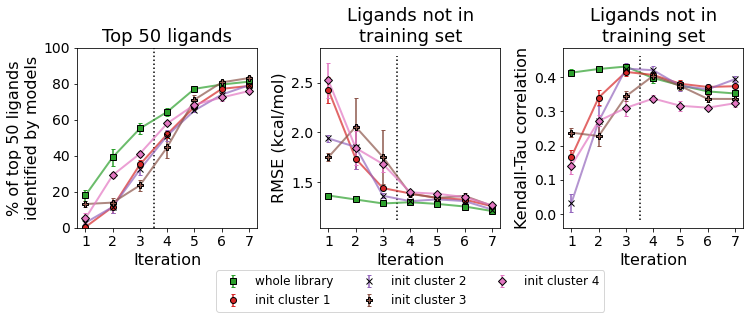

In [41]:
import matplotlib.ticker as ticker

pgroups=["top50_correctly_predicted", "RMSD_unmeasured", "KT_unmeasured"]
labels=["% of top 50 ligands\nidentified by models", "RMSE (kcal/mol)", "Kendall-Tau correlation"]
titles=["Top 50 ligands", "Ligands not in\ntraining set", "Ligands not in\ntraining set"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=0.7

n_sub_plots=len(pgroups)
n_sp_x=width=n_sub_plots
n_sp_y=height=1
subp_size=2.5

hspace=0.05#*(height)
wspace=0.35#*(width)

t_pad_factor_h=0.25 #of subp_size
b_pad_factor_h=0.55#0.2 #of subp_size
r_pad_factor_w=0.12#0.05 #of subp_size
l_pad_factor_w=0.40#0.32 #of subp_size
pad_factor_to_cbar=0 #of subp_size
pad_factor_w=(r_pad_factor_w+l_pad_factor_w)*0.5+pad_factor_to_cbar
pad_factor_h=(t_pad_factor_h+b_pad_factor_h)*0.5
fig_h=(height+2*pad_factor_h+(height-1)*hspace)*subp_size
fig_w=(width+2*pad_factor_w+(width-1)*wspace)*subp_size #- 0.6*subp_size

top_pad=t_pad_factor_h*subp_size/fig_h
bot_pad=b_pad_factor_h*subp_size/fig_h
right_pad=r_pad_factor_w*subp_size/fig_w
left_pad=l_pad_factor_w*subp_size/fig_w

print("figsize:", [fig_w, fig_h])

fig, axs = plt.subplots(height, width, figsize=[fig_w, fig_h], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    plt.xlabel("Iteration", size=16)
    plt.ylabel(labels[sp], size=16)
    axs[sp].xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.title(titles[sp], size=18)
    
    plt.tick_params(axis='x', labelsize=14 )
    plt.tick_params(axis='y', labelsize=14 )
    
#     if(sp!=0):
#         axs[sp].axes.yaxis.set_ticklabels([])
#         axs[sp].set_ylabel("")

    
    for cnum in range(len(init_method_names)):
        lbl=init_method_names[cnum]
#         if(lbl=="random" and sp!=2):
#             continue;

        if(not("random" in lbl or "cluster" in lbl)):
            continue;
    
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_init_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_init_method[cnum], atrname+"_err")
        
        if(atrname=="top50_found" or atrname=="top50_correctly_predicted"):
            y_avg=y_avg*100/50
            y_sem=y_sem*100/50
            plt.gca().set_ylim(0,100)
        
        #x=getattr(run_mean_hist_by_sele_method[cnum], "num_known_ligs_at_step")*100/2351
        x=np.arange(7)+1
        
        ls="solid"
        lw=2
        if("init_cluster" in lbl):
            facecolor='None'
            fs='none'
        else:
            facecolor=f"C{cnum+2}"
            fs='full'
            
        if("init_weighted_2D" in lbl):
            lbl="weighted random"
        elif("init_random" in lbl):
            lbl="whole library"
        
        plt.plot(x, y_avg, linestyle=ls, c=facecolor, markerfacecolor=facecolor, fillstyle=fs, linewidth=lw, alpha=alpha)
        plt.errorbar(x, y_avg, yerr=y_sem, c=facecolor, markerfacecolor=facecolor,
                     marker=markers[cnum], capsize=2, linestyle="None", fillstyle=fs, label=lbl, markeredgecolor='k')

    xlim=plt.gca().get_xlim()
    
    #diag=np.arange(0,100, 2)
    #plt.plot(diag, diag+100*100/2351, ls='dashed', color='grey')

    #plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
    #plt.gca().set_ylim((0,250))

    #plt.vlines(100*7*(2.5+1)/2351, 0, 100, colors="black", linestyles='dotted')
    #plt.vlines(100*3.5*100/2351, 0, 100, colors="black", linestyles='dotted')
    
    ylim=plt.gca().get_ylim()
    plt.vlines(3.5, ylim[0], ylim[1], colors="black", linestyles='dotted')
    #plt.gca().set_ylim((0,100))
    plt.gca().set_xlim((xlim[0],xlim[1]))
    
    #plt.suptitle("Convergence metrics for top 50 strongest binding ligands", size=20)
    #plt.tight_layout(rect=[0, 0.07, 1, 1])

plt.subplots_adjust(top=1-top_pad, right=1-right_pad, wspace=wspace, hspace=hspace, left=left_pad, bottom=bot_pad)
    
#axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=4)
#axs[2].legend(loc='lower center', bbox_to_anchor=(-0.75, -0.32), ncol=5, prop={'size': 12})
if(n_sub_plots%2==0):
    legend_shift=0    
else:
    legend_shift=0.5
axs[int(n_sub_plots/2)].legend(loc='lower center', bbox_to_anchor=(legend_shift, -0.50), ncol=3, prop={'size': 12})

plt.savefig(f"init_method_convergence_narrowing.png",
                dpi=300,
                facecolor='w'
               )
plt.show()